# Fraud Detection for Financial Transactions

This notebook presents an end-to-end fraud detection approach using machine learning, including data cleaning, exploratory analysis, model development, fine-tuning, and business interpretation.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [7]:
import kagglehub

path = kagglehub.dataset_download("chitwanmanchanda/fraudulent-transactions-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\chitwanmanchanda\fraudulent-transactions-data\versions\1


In [8]:
import os

csv_path = os.path.join(path, "Fraud.csv")
df = pd.read_csv(csv_path)

df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Understanding

In [9]:
df.shape

(6362620, 11)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [11]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## Exploratory Data Analysis (EDA)

In [12]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [13]:
df['isFraud'].value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

<Axes: xlabel='isFraud', ylabel='count'>

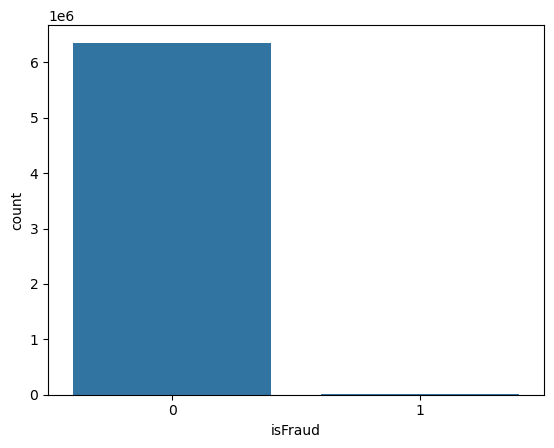

In [14]:
sns.countplot(x='isFraud', data=df)

In [15]:
pd.crosstab(df['type'], df['isFraud'], normalize='index')

isFraud,0,1
type,,
CASH_IN,1.000000,0.000000
CASH_OUT,0.998160,0.001840
DEBIT,1.000000,0.000000
PAYMENT,1.000000,0.000000
TRANSFER,0.992312,0.007688


In [16]:
df.duplicated().sum()

0

## Data Cleaning


In [17]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)

## Outlier Analysis

<Axes: xlabel='amount'>

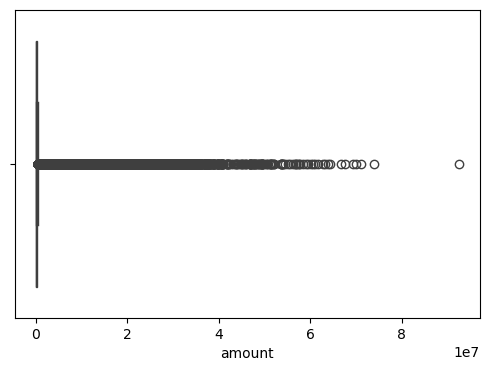

In [18]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['amount'])

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Feature Encoding and Correlation Analysis

In [20]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

<Axes: >

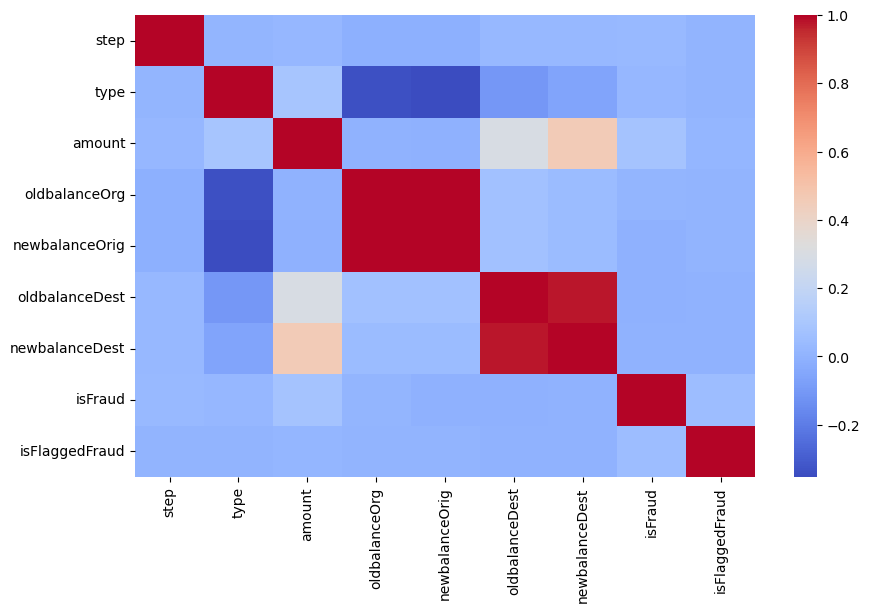

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap='coolwarm')

## Train–Test Split (Time-Based)

In [22]:
split_step = df['step'].quantile(0.8)

train = df[df['step'] <= split_step]
test  = df[df['step'] > split_step]

In [23]:
X_train = train.drop('isFraud', axis=1)
y_train = train['isFraud']

X_test = test.drop('isFraud', axis=1)
y_test = test['isFraud']

In [24]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

## Baseline Model: Logistic Regression

In [25]:
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000
)

lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [26]:
y_prob_lr = lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_prob_lr > 0.5).astype(int)  

print("Logistic Regression – Classification Report")
print(classification_report(y_test, y_pred_lr))

print("Logistic Regression – ROC AUC")
print(roc_auc_score(y_test, y_prob_lr))

Logistic Regression – Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1244486
           1       0.15      0.77      0.26      4250

    accuracy                           0.98   1248736
   macro avg       0.58      0.88      0.63   1248736
weighted avg       1.00      0.98      0.99   1248736

Logistic Regression – ROC AUC
0.9588468280455216


## Final Model: Random Forest Classifier

In [26]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [33]:
y_prob_rf = rf.predict_proba(X_test)[:,1]

## Model Evaluation (ROC-AUC)

In [34]:
roc_auc_score(y_test, y_prob_rf)

0.9734912105928732

## Threshold Fine-Tuning and Evaluation


Threshold = 0.1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1244486
           1       0.99      0.76      0.86      4250

    accuracy                           1.00   1248736
   macro avg       1.00      0.88      0.93   1248736
weighted avg       1.00      1.00      1.00   1248736



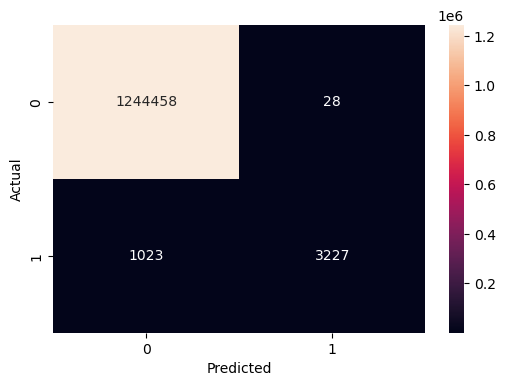


Threshold = 0.2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1244486
           1       1.00      0.74      0.85      4250

    accuracy                           1.00   1248736
   macro avg       1.00      0.87      0.92   1248736
weighted avg       1.00      1.00      1.00   1248736



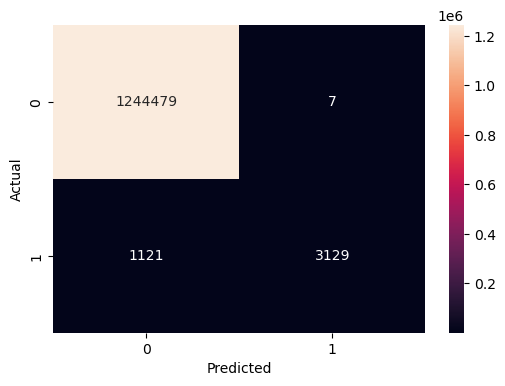


Threshold = 0.3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1244486
           1       1.00      0.72      0.84      4250

    accuracy                           1.00   1248736
   macro avg       1.00      0.86      0.92   1248736
weighted avg       1.00      1.00      1.00   1248736



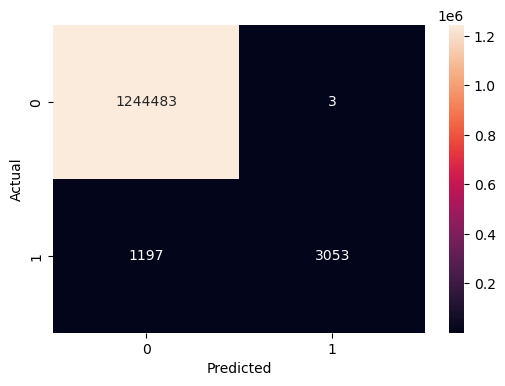

In [35]:
thresholds = [0.1, 0.2, 0.3]

for t in thresholds:
    print(f"\nThreshold = {t}")
    
    y_pred_rf = (y_prob_rf > t).astype(int)
    
    print(classification_report(y_test, y_pred_rf))
    
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## Answers to Candidate Expectations


### Q.1) Data Cleaning

The dataset was examined for missing values and duplicates, and no missing or duplicate records were found. Identifier variables such as `nameOrig` and `nameDest` were removed, as they do not generalize across customers.

Outliers in transaction amounts were retained because unusually large transactions are often indicative of fraudulent behavior rather than noise. Multicollinearity among numerical features was examined using a correlation heatmap. Although some balance related variables showed high correlation, they were retained due to their strong business relevance and the ability of tree-based models to handle correlated features.


### Q.2) Fraud Detection Model

A Random Forest classifier was used as the primary fraud detection model due to its ability to capture non-linear relationships in transactional data. A Logistic Regression model was also trained as a baseline for comparison.

Although the dataset is highly imbalanced, resampling techniques such as SMOTE or random undersampling were not used. The dataset contains a sufficient number of real fraudulent transactions, and altering the class distribution could distort real-world transaction patterns.

Instead, class weighting and probability threshold tuning were applied to penalize misclassification of fraud more heavily. This approach preserves the original data distribution while aligning the model with business costs associated with missed fraud and false positives.


### Q.3) Variable Selection

Variables were selected based on domain knowledge, exploratory data analysis, and their relevance to transaction behavior. Features related to transaction type, amount, and account balance changes were retained, as they directly reflect customer activity patterns.

Identifier columns were excluded, while correlated balance features were preserved due to their interpretability and predictive value in detecting abnormal fund movements.


### Q.4) Model Performance

Model performance was evaluated using metrics suitable for imbalanced classification problems, including precision, recall, F1-score, ROC-AUC, and the confusion matrix. Accuracy was not emphasized, as it can be misleading in fraud detection contexts.

The Random Forest model achieved a high ROC-AUC score, indicating strong discriminatory power between fraudulent and legitimate transactions. The confusion matrix further illustrates the trade-off between fraud detection and false positives.


### Q.5) Key Fraud Predictors

Key predictors of fraudulent transactions include transaction type, transaction amount, and balance inconsistencies before and after transactions. Fraud is predominantly observed in `TRANSFER` and `CASH_OUT` transaction types.

Sudden depletion of the origin account and abnormal increases in destination balances were strong indicators of fraudulent behavior.


### Q.6) Interpretation of Predictive Factors

Yes, these factors align with real world fraud behavior. Fraudsters often attempt to rapidly transfer or withdraw funds, resulting in large transaction amounts and unusual balance changes.

The concentration of fraud in specific transaction types and the presence of abnormal balance patterns are consistent with known account takeover and money laundering scenarios.


### Q.7) Fraud Prevention Strategies

A layered fraud prevention approach should be adopted, combining machine learning based risk scoring with rule based checks. High risk transactions can be flagged for additional verification, such as OTP authentication or temporary account holds.

Transaction speed monitoring, anomaly detection, and manual review workflows can further enhance fraud prevention while minimizing customer friction.


### Q.8) Measuring Effectiveness

The effectiveness of fraud prevention strategies can be measured by monitoring key metrics such as fraud loss reduction, recall and precision stability, false positive rates, and customer complaints.

A/B testing can be done by running the new fraud detection model alongside the existing system on a subset of transactions and comparing their performance. The model should also be monitored regularly to ensure it continues to perform well over time.


### Model Choice Consideration

Advanced models such as XGBoost or Gradient Boosting could also be applied to this fraud detection problem, as they are commonly used for tabular financial data. However, a Random Forest model was selected to maintain simplicity, interpretability, and lower computational complexity while still achieving strong performance.

The focus of this project was placed on proper data understanding, handling class imbalance, preventing data leakage, and tuning decision thresholds based on business trade-offs rather than aggressive model optimization.
